# Model used in the scraping

This notebook features the model selected for scraping. 

In [2]:
%run notebook_utils.py

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
import matplotlib

# set big font in plots
SMALL_SIZE = 20
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

In [13]:
import re

reg_nonletters_v0 = re.compile("[^\w \.,]|\d|_")

def remove_nonletters_v0(text: str) -> str: return re.sub(reg_nonletters_v0, " ", text)

def remove_manyspaces_v0(text: str) -> str: return re.sub(r'\s+', ' ', text)

def sanitize_v0(text: str) -> str:
    text = text.lower()
    text = remove_nonletters_v0(text)
    text = remove_manyspaces_v0(text)
    return text.strip()

np_sanitize = np.vectorize(sanitize_v0)

## Data loading

In [6]:
X, y = load_data()

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=0)
sms_any_X, sms_any_y = load_sms_any()
X_valid, y_valid = load_validation_data()

In [12]:
#import pickle
#m = pickle.load(open('/Users/Lin/git/SwigSpot/language-detection-webapp/langid/_pickles/model_3-5grams-sg-feat6000-tf-idf_logreg.pickle', 'rb'))

m.named_steps['vec'].get_params(True)

{'analyzer': 'char',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 6000,
 'min_df': 1,
 'ngram_range': (3, 5),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': True,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [19]:
X_train[y_train == 4].size

5949

# Model training

In [20]:
vect_options = dict(
    analyzer='char', 
    max_features=6000, 
    ngram_range=(3, 5),
    sublinear_tf=True, 
    use_idf=True
)

logreg_options = dict(C=1)

pipe = Pipeline([
    ('vec', TfidfVectorizer(**vect_options)),
    ('clf', LogisticRegression(**logreg_options))
])


pipe.named_steps['vec'].fit(np_sanitize(X_train[y_train == 4]))
pipe.named_steps['clf'].fit(pipe.named_steps['vec'].transform(np_sanitize(X_train)), y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Model evaluation

TEST SET
accuracy: 0.9915

             precision    recall  f1-score   support

         de     0.9959    0.9850    0.9904      1462
         fr     0.9966    0.9952    0.9959      1468
         en     0.9967    0.9876    0.9922      1538
         it     0.9966    0.9966    0.9966      1482
         sg     0.9714    0.9930    0.9821      1438

avg / total     0.9916    0.9915    0.9915      7388



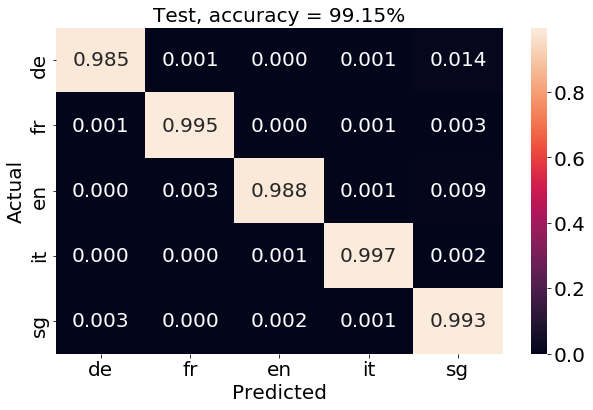

SMS RECALL
total samples    10692
total errors        57 (0.53%)
---------------------------------
languages detected
    de       47
    fr        1
    en        3
    it        6
    sg    10635


SMS ANY
accuracy: 0.8408

             precision    recall  f1-score   support

         de     1.0000    0.6965    0.8211       201
         fr     0.9834    0.8856    0.9319       201
         en     0.9783    0.6716    0.7965       201
         it     0.9948    0.9502    0.9720       201
         sg     0.5678    1.0000    0.7243       201

avg / total     0.9049    0.8408    0.8492      1005



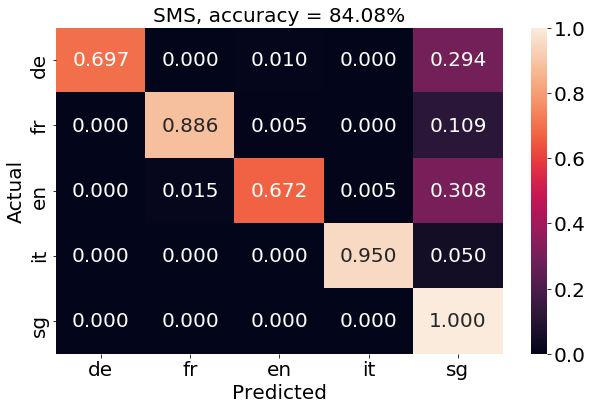



VALIDATION SET
accuracy: 0.9827

             precision    recall  f1-score   support

         de     0.9461    0.9870    0.9661      2613
         fr     0.9973    0.9966    0.9969      2613
         en     0.9969    0.9935    0.9952      2613
         it     0.9977    0.9969    0.9973      2613
         sg     0.9769    0.9395    0.9579      2613

avg / total     0.9830    0.9827    0.9827     13065



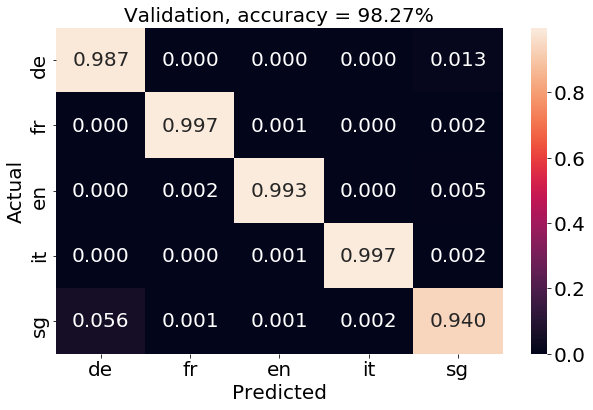

In [21]:
print("TEST SET")
print("========")
y_pred = pipe.predict(np_sanitize(X_test))
print_results(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred, normalised=True, 
    title="Test, accuracy = %.2f%%" % (metrics.accuracy_score(y_test, y_pred) * 100))
print("SMS RECALL")
print("==========")

test_recall_with_sms(pipe)

print("\n\nSMS ANY")
print("==========")
y_sms_any_pred = pipe.predict(np_sanitize(sms_any_X))
print_results(sms_any_y, y_sms_any_pred)
plot_confusion_matrix(sms_any_y, y_sms_any_pred, normalised=True,
    title="SMS, accuracy = %.2f%%" % (metrics.accuracy_score(sms_any_y, y_sms_any_pred) * 100))

print("\n\nVALIDATION SET")
print("===============")
y_valid_pred = pipe.predict(np_sanitize(X_valid))
print_results(y_valid, y_valid_pred)
plot_confusion_matrix(y_valid, y_valid_pred, normalised=True,
    title="Validation, accuracy = %.2f%%" % (metrics.accuracy_score(y_valid, y_valid_pred) * 100))

# Model export

In [8]:
import pickle

filename = "Sanitize_v0-TfidfVec_feat6000_3-5grams_sg-only-logreg_C1.pickle"
with open(filename, 'wb') as f: pickle.dump(pipe, f)